In [4]:
# import gdown
# from zipfile import ZipFile

# gdown.download ('http://images.cocodataset.org/zips/train2017.zip','./data/train2017.zip') 
# gdown.download ('http://images.cocodataset.org/zips/val2017.zip', './data/val2017.zip')
# gdown.download ("http://images.cocodataset.org/annotations/annotations_trainval2017.zip",'./data/annotations_trainval2017.zip') 
  
# !cd data && unzip -q train2017.zip
# !cd data && unzip -q val2017.zip
# !cd data && unzip -q annotations_trainval2017.zip 

# !cd data && git clone https://github.com/cocodataset/cocoapi
# !cd data/cocoapi/PythonAPI && cmake 


Usage

  cmake [options] <path-to-source>
  cmake [options] <path-to-existing-build>
  cmake [options] -S <path-to-source> -B <path-to-build>

Specify a source directory to (re-)generate a build system for it in the
current working directory.  Specify an existing build directory to
re-generate its build system.

Run 'cmake --help' for more information.



### Импорт необходимых библиотек

In [1]:
import os
import skimage.io as io
import numpy as np

### Импорт TensorFlow

In [2]:
import tensorflow as tf
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.10.0


### Импорт библиотеки COCO API
Там содержатся различные функции для чтения и обработки датасета COCO

In [3]:
COCO_ROOT = r'C:\Users\vahahat\Desktop\SKILLBOX\HOMEWORK\ML MID\Semantic segmentation\data'
import sys
from pycocotools import _mask
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котром не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [10]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [11]:
class COCO_Dataset(Dataset):
    
    

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)
 
        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и вализационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset` (в первом и втором случае логика и пайплайн данных в этих датасетов отличаются)

In [12]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=15.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [14]:
batch_size = 32
epochs = 10
inp_size = 256
train_ds = COCO_dataset_train.train_dataset(batch_size=batch_size, epochs=epochs, inp_size=inp_size)
val_ds = COCO_dataset_val.val_dataset(batch_size=batch_size, inp_size=inp_size)

In [15]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(32, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(32, 256, 256, None), dtype=tf.float32, name=None))>

In [16]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(32, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(32, None, None, None), dtype=tf.float32, name=None))>

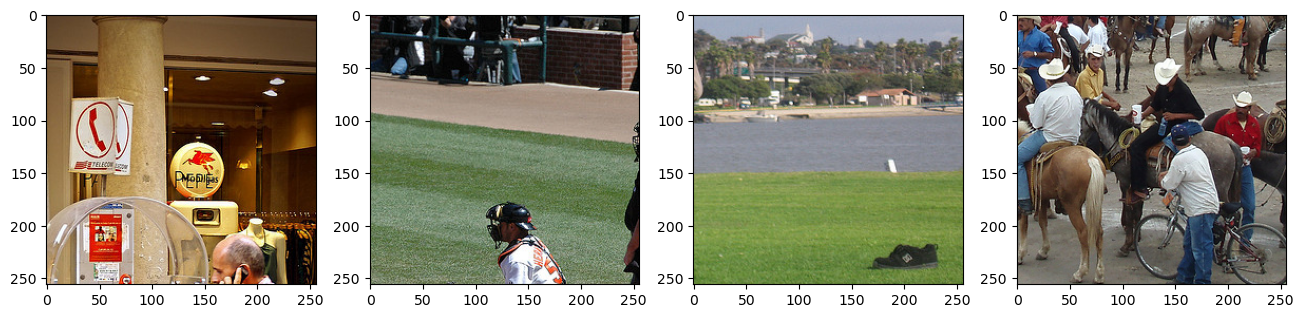

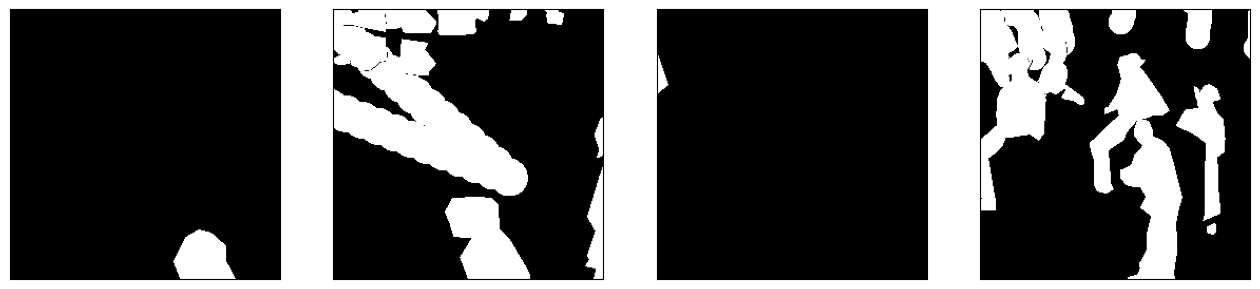

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
some_samples = [x for x in iter(train_ds.take(4))]   # train_ds — объект класса Dataset


fig = plt.figure(figsize=(16, 16))


for i in range(len(some_samples)):
    ax1 = fig.add_subplot(1, 4, i+1)
    # print(some_samples[i][0].shape)
    # print(some_samples[i][1].shape)
    ax1.imshow(some_samples[i][0][0])


fig = plt.figure(figsize=(16, 16))
for i in range(len(some_samples)):
    ax2 = fig.add_subplot(1, 4, i+1)
    ax2.imshow(some_samples[i][1][0].numpy().reshape(256, 256), cmap='gray')
    plt.xticks([]), plt.yticks([])


plt.show()

In [47]:
def aspp(inp):
  out1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')(inp)
  out2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')(inp)
  out3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')(inp)
  out4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')(inp)
  out = tf.concat([out1, out2, out3, out4], axis=3)
  out = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')(out)
  return out
def build_model():
        x = tf.keras.layers.Input((256, 256, 3))
        out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
        out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
        out = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(out)
        out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
        out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
        out = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(out)
        out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
        out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)


        out_enc_mid = out


        out = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(out)
        out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
        out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
        out = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(out)
        out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
        out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)


        out = aspp(out)
        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)
        out_enc_mid = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')(out_enc_mid)


        out = tf.concat([out, out_enc_mid], axis=3)
        out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
        out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
        out = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)(out)
        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)


        return tf.keras.Model(inputs=x, outputs=out)


model = build_model()
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', metrics=['accuracy'], loss=loss)
history = model.fit(train_ds, epochs=1)

20035/20035 [==============================] - 12434s 619ms/step - loss: 0.2443 - accuracy: 0.8931


In [49]:
model = build_model()
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', metrics=['accuracy'], loss=loss)
history = model.fit(train_ds, epochs=3)

Epoch 1/3
20035/20035 [==============================] - 12307s 614ms/step - loss: 0.2492 - accuracy: 0.8910
Epoch 2/3
20035/20035 [==============================] - 12480s 623ms/step - loss: 0.1801 - accuracy: 0.9256
Epoch 3/3
20035/20035 [==============================] - 12523s 625ms/step - loss: 0.1609 - accuracy: 0.9347


In [50]:
model.save("semantic_segmentation_COCO_ASPP_93AC.h5")

In [93]:
from PIL import Image
img = Image.open(r"C:\Users\vahahat\Desktop\0yKtWCVfLhU.jpg")
img = img.resize((256, 256))
img_array = np.array(img)
img_array = img_array.astype('float32') / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)

1/1 [==============================] - 0s 17ms/step


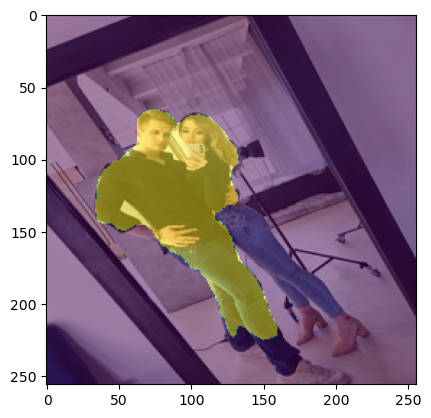

In [99]:
threshold = 0.5
mask = (prediction > threshold).astype(np.uint8)[0]
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.imshow(img_array[0])
ax.imshow(mask, alpha=0.5)
plt.savefig('overlay.jpg')

1/1 [==============================] - 0s 18ms/step


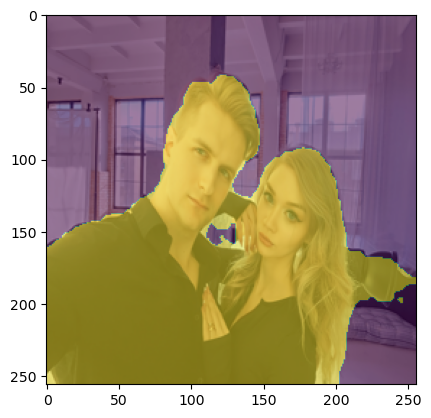

In [108]:
img = Image.open(r"C:\Users\vahahat\Desktop\eLGq7aKKUhc.jpg")
img = img.resize((256, 256))
img_array = np.array(img)
img_array = img_array.astype('float32') / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
threshold = 0.6
mask = (prediction > threshold).astype(np.uint8)[0]
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.imshow(img_array[0])
ax.imshow(mask, alpha=0.5)
plt.savefig('overlay.jpg')